# Graph-UNets

Hereafter is a modification of the implementation of the paper. Only the encoder is considered here, we can think of it as a graph CNN. Additionaly, we inserted residual connections.

## Imports

In [2]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import nn
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool
from torch_geometric import seed_everything
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.utils.sparse import dense_to_sparse,to_torch_coo_tensor
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Dataset

For our experiment we picked the PROTEINS dataset, which is one of those selected in the Graph-UNets paper.  
The dataset was divided as such:
- 81% for the training set
- 9% for the validation set
- 10 % for the test set

In [3]:
seed_everything(77) #Seed for all random actions, this library is a proxy for other libraries, e.g. pytorch
path=""
dataset = TUDataset(path, name='PROTEINS').shuffle() #Here we shuffle the dataset to break any potential order correlation

print("Dataset is undirected? ", dataset[0].is_undirected()) #This is a vital information!
print ("Len of dataset: ", len(dataset))
train_set = dataset[:int(0.9*len(dataset))]
train_dataset = train_set[:int(0.9*len(train_set))]
val_dataset = train_set[int(0.9*len(train_set)):]
test_dataset = dataset[int(0.9*len(dataset)):]
print("Len of train dataset: ", len(train_dataset))
print("Len of validation dataset: ",len(val_dataset))
print("Len of test dataset: ",len(test_dataset))

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset is undirected?  True
Len of dataset:  1113
Len of train dataset:  900
Len of validation dataset:  101
Len of test dataset:  112


## Graph Pooling

![title](graphpool.png)

In [4]:
class gPool(nn.Module):
    """
    Our implementation of the pooling methodology described in the paper, above you can see the pseudocode
    """
    def __init__(self,in_dim,ratio):
        super().__init__()
        self.in_dim=in_dim
        self.ratio=ratio
        self.p=nn.Linear(in_dim,1)
        self.sigmoid=nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,edge_index,batch):
        
        #y is described as a learnable projection, hence we estimated a linear layer to be a suitable choice
        
        y=self.p(xl) #/torch.norm(self.p(xl)) #DO WE HAVE TO INSERT THE NORM?
        
        k=int(self.ratio*len(y))#Number of selected nodes, the k in TopkPooling
        
        topks, idx =torch.topk(y,k,dim=0) #The k elements with top scores, and their corresponding idx
        
        y_hat=self.sigmoid(topks)
        xl_hat=xl[idx,:].squeeze() #Feature matrix of topk nodes
        xl1=xl_hat * y_hat  #Gate operation
        
        al = torch.as_tensor(to_scipy_sparse_matrix(edge_index,num_nodes=len(y)).todense(), device = self.device)
        al1 = torch.index_select(torch.as_tensor(al),0,idx.squeeze()) #no direct indexing because of ram overloading
        al1=torch.index_select(al1,1,idx.squeeze())
        sparsel1=dense_to_sparse(al1)
        edge_index_pooled=torch.sparse_coo_tensor(sparsel1[0],sparsel1[1]).coalesce().indices() #Our model elaborates coo tensors
        
        batch = batch[idx.squeeze()]
        
        return xl1, edge_index_pooled, idx.squeeze(), batch

In [4]:
"""
Simple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension
p=nn.Linear(4,1)
xl=torch.ones((6,4))
y=p(xl)/torch.norm(p(xl))
xl2=torch.ones((2,4))
print(torch.norm(p(xl),dim=0))
print(torch.norm(p(xl2),dim=0))
"""

'\nSimple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension\np=nn.Linear(4,1)\nxl=torch.ones((6,4))\ny=p(xl)/torch.norm(p(xl))\nxl2=torch.ones((2,4))\nprint(torch.norm(p(xl),dim=0))\nprint(torch.norm(p(xl2),dim=0))\n'

## U-Net

The U-Net as described in the paper, below is the graphical representation in the paper, however the number of up and down blocks is inferior with respect to the paper description, which is four upblocks and four downblocks as presented in the code below.

![title](unet_structure.png)

In [11]:
class UNet(nn.Module):
    def __init__(self, improved = False, dropout = 0.3 ):
        super().__init__()
        """
        For the original operation we adoperated GCNConv, considered one of the "basic" convolutional layer for graphs
        """
        self.in_conv = GCNConv(dataset.num_features, 16, improved= improved)
        
        self.GC1 = GCNConv(16, 32, dropout= dropout, improved= improved) 
        self.GC2 = GCNConv(32, 64, dropout= dropout, improved= improved)
        self.GC3 = GCNConv(64, 128, dropout= dropout, improved= improved)
        self.GC4 = GCNConv(128, 256,dropout= dropout, improved= improved)
        self.act=nn.ELU()
        
        self.GCx3 = GCNConv(32, 32,dropout= dropout, improved= improved)
        self.GCx5 = GCNConv(64, 64, dropout= dropout, improved= improved)
        self.GCx7 = GCNConv(128, 128, dropout= dropout, improved= improved)
        self.GCx9 = GCNConv(256, 256,dropout= dropout, improved= improved)
        
        self.gPool1 = gPool(16, 0.9)
        self.gPool2 = gPool(32, 0.7)
        self.gPool3 = gPool(64, 0.6)
        self.gPool4 = gPool(128, 0.5)
        
        self.out_conv = GCNConv(256, dataset.num_features, improved= improved)
        
        self.linear = nn.Linear(dataset.num_features, 1)
    
    def forward(self,x,edge_index,batch,batch_size):
        x1 = self.in_conv(x, edge_index)
        x1 = self.act(x1)
        
        # Encoder
        
        #Pool1
        x2, edge_index2, idx2, batch= self.gPool1(x1,edge_index,batch)
        x2 = self.act(x2)
        
        x3 = self.GC1(x2, edge_index2)
        x3 = self.act(x3 + self.GCx3(x3, edge_index2)) 
        
        #Pool2
        x4,  edge_index4, idx4, batch = self.gPool2(x3,edge_index2, batch)
        x4 = self.act(x4)
        
        x5 = self.GC2(x4, edge_index4)
        x5 = self.act(x5 + self.GCx5(x5, edge_index4))
        
        #Pool3
        x6,  edge_index6, idx6, batch= self.gPool3(x5,edge_index4, batch)
        x6 = self.act(x6)
        
        x7 = self.GC3(x6, edge_index6)
        x7 = self.act(x7 + self.GCx7(x7, edge_index6))
        
        #Pool4
        x8,  edge_index8, idx8, batch= self.gPool4(x7,edge_index6, batch)
        x8 = self.act(x8)
        
        x9 = self.GC4(x8, edge_index8)
        x9 = self.act(x9 + self.GCx9(x9, edge_index8))
        
        x10=self.out_conv(x9, edge_index8)
        x10=self.act(x10)
        
        #Readout
        x10 = global_mean_pool(x10, batch, batch_size) #readout layer commonly adoperated - reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l
        x10 = self.act(x10)
        
        #Linear
        x10=self.linear(x10)
        
        return x10

## Parameters customization

In [12]:
seed_everything(77)
lrate =0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=UNet(improved=False, dropout=0.3).to(device) #Customize the model by changing these parameters

optimizer = torch.optim.Adam(model.parameters(), lr=lrate) #Adam because it is adaptive
criterion=nn.BCEWithLogitsLoss()
sigmoid=nn.Sigmoid()
epochs=200

## Training

Here we start the training of the model, we perform one epoch on the training set and one on the validation set.

In [13]:
seed_everything(77)
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc=0.0
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device) #E.g. DataBatch(edge_index=[2, 19062], x=[5024, 3], y=[128], batch=[5024], ptr=[129])
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        loss.backward()
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        train_acc+=acc
        train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss=train_loss/len(train_loader) #We compute the average train loss for each epoch
    train_losses.append(epoch_train_loss)
    epoch_train_accuracy=train_acc/len(train_loader) #We compute the average train accuracy for each epoch
    train_accuracies.append(epoch_train_accuracy)
    print(f"Training loss epoch {epoch}: ", epoch_train_loss)
    print(f"Training accuracy epoch {epoch}: ", epoch_train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_acc=0.0
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        val_acc+=acc
        val_loss += loss.item()
    
    epoch_val_loss=val_loss/len(val_loader) #We compute the average validation loss for each epoch
    val_losses.append(epoch_val_loss)
    epoch_val_accuracy=val_acc/len(val_loader) #We compute the average validation accuracy for each epoch
    val_accuracies.append(epoch_val_accuracy)
    print(f"Validation loss epoch {epoch}: ", epoch_val_loss)
    print(f"Validation accuracy epoch {epoch}: ", epoch_val_accuracy)
print('Finished Training')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 0:  0.6696633324027061
Training accuracy epoch 0:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 0:  0.6775484085083008
Validation accuracy epoch 0:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 1:  0.6760974675416946
Training accuracy epoch 1:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Validation loss epoch 1:  0.6714232563972473
Validation accuracy epoch 1:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 2:  0.6484756097197533
Training accuracy epoch 2:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.12it/s]


Validation loss epoch 2:  0.668381929397583
Validation accuracy epoch 2:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.34it/s]


Training loss epoch 3:  0.6154766418039799
Training accuracy epoch 3:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


Validation loss epoch 3:  0.686487078666687
Validation accuracy epoch 3:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


Training loss epoch 4:  0.6819992884993553
Training accuracy epoch 4:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


Validation loss epoch 4:  0.6827871203422546
Validation accuracy epoch 4:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 5:  0.6445990800857544
Training accuracy epoch 5:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 5:  0.6721093058586121
Validation accuracy epoch 5:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 6:  0.6722266748547554
Training accuracy epoch 6:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


Validation loss epoch 6:  0.6741533875465393
Validation accuracy epoch 6:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 7:  0.6603380218148232
Training accuracy epoch 7:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.57it/s]


Validation loss epoch 7:  0.6712133288383484
Validation accuracy epoch 7:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 8:  0.6438532546162605
Training accuracy epoch 8:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 8:  0.673299252986908
Validation accuracy epoch 8:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 9:  0.6853974983096123
Training accuracy epoch 9:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Validation loss epoch 9:  0.6780087351799011
Validation accuracy epoch 9:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.64it/s]


Training loss epoch 10:  0.6290699765086174
Training accuracy epoch 10:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]


Validation loss epoch 10:  0.6730230450630188
Validation accuracy epoch 10:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 11:  0.6186975240707397
Training accuracy epoch 11:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.53it/s]


Validation loss epoch 11:  0.6816715002059937
Validation accuracy epoch 11:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Training loss epoch 12:  0.6598516404628754
Training accuracy epoch 12:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


Validation loss epoch 12:  0.693255603313446
Validation accuracy epoch 12:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 13:  0.6508221626281738
Training accuracy epoch 13:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Validation loss epoch 13:  0.6782611608505249
Validation accuracy epoch 13:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Training loss epoch 14:  0.6169807612895966
Training accuracy epoch 14:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Validation loss epoch 14:  0.6759031414985657
Validation accuracy epoch 14:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.14it/s]


Training loss epoch 15:  0.6523209884762764
Training accuracy epoch 15:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.22it/s]


Validation loss epoch 15:  0.6849249601364136
Validation accuracy epoch 15:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.27it/s]


Training loss epoch 16:  0.6647881865501404
Training accuracy epoch 16:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


Validation loss epoch 16:  0.6695491075515747
Validation accuracy epoch 16:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 17:  0.6540636867284775
Training accuracy epoch 17:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


Validation loss epoch 17:  0.666682243347168
Validation accuracy epoch 17:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.86it/s]


Training loss epoch 18:  0.6456759497523308
Training accuracy epoch 18:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


Validation loss epoch 18:  0.6734023690223694
Validation accuracy epoch 18:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.73it/s]


Training loss epoch 19:  0.6638142317533493
Training accuracy epoch 19:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.03it/s]


Validation loss epoch 19:  0.6833934783935547
Validation accuracy epoch 19:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]


Training loss epoch 20:  0.6552473306655884
Training accuracy epoch 20:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 20:  0.668871283531189
Validation accuracy epoch 20:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 21:  0.6662106439471245
Training accuracy epoch 21:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]


Validation loss epoch 21:  0.6659263372421265
Validation accuracy epoch 21:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Training loss epoch 22:  0.6301572620868683
Training accuracy epoch 22:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


Validation loss epoch 22:  0.6617166996002197
Validation accuracy epoch 22:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.40it/s]


Training loss epoch 23:  0.6259193569421768
Training accuracy epoch 23:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 23:  0.6920517086982727
Validation accuracy epoch 23:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 24:  0.6495052352547646
Training accuracy epoch 24:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 24:  0.671524167060852
Validation accuracy epoch 24:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 25:  0.6630416512489319
Training accuracy epoch 25:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 25:  0.666316568851471
Validation accuracy epoch 25:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.79it/s]


Training loss epoch 26:  0.6735553592443466
Training accuracy epoch 26:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.75it/s]


Validation loss epoch 26:  0.6669674515724182
Validation accuracy epoch 26:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.84it/s]


Training loss epoch 27:  0.6526239812374115
Training accuracy epoch 27:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.86it/s]


Validation loss epoch 27:  0.6657025814056396
Validation accuracy epoch 27:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.32it/s]


Training loss epoch 28:  0.6261304095387459
Training accuracy epoch 28:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.03it/s]


Validation loss epoch 28:  0.6700791120529175
Validation accuracy epoch 28:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 29:  0.6442444697022438
Training accuracy epoch 29:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.25it/s]


Validation loss epoch 29:  0.6718814969062805
Validation accuracy epoch 29:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.01it/s]


Training loss epoch 30:  0.6383690312504768
Training accuracy epoch 30:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Validation loss epoch 30:  0.6510399580001831
Validation accuracy epoch 30:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 31:  0.6372347697615623
Training accuracy epoch 31:  0.6201171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 31:  0.6392424702644348
Validation accuracy epoch 31:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 32:  0.6403631567955017
Training accuracy epoch 32:  0.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 32:  0.6882753968238831
Validation accuracy epoch 32:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.40it/s]


Training loss epoch 33:  0.6072239577770233
Training accuracy epoch 33:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 33:  0.6575474143028259
Validation accuracy epoch 33:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.67it/s]


Training loss epoch 34:  0.5871049724519253
Training accuracy epoch 34:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 34:  0.6818796396255493
Validation accuracy epoch 34:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.31it/s]


Training loss epoch 35:  0.6151337698101997
Training accuracy epoch 35:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Validation loss epoch 35:  0.6829144954681396
Validation accuracy epoch 35:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 36:  0.618621252477169
Training accuracy epoch 36:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 36:  0.6717411279678345
Validation accuracy epoch 36:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Training loss epoch 37:  0.6338291987776756
Training accuracy epoch 37:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


Validation loss epoch 37:  0.656986653804779
Validation accuracy epoch 37:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.07it/s]


Training loss epoch 38:  0.5986611247062683
Training accuracy epoch 38:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 38:  0.6665462851524353
Validation accuracy epoch 38:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.34it/s]


Training loss epoch 39:  0.6000761613249779
Training accuracy epoch 39:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 39:  0.6958122253417969
Validation accuracy epoch 39:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 40:  0.6609001234173775
Training accuracy epoch 40:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


Validation loss epoch 40:  0.656562864780426
Validation accuracy epoch 40:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.49it/s]


Training loss epoch 41:  0.6472867205739021
Training accuracy epoch 41:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 41:  0.6633360981941223
Validation accuracy epoch 41:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 42:  0.6650242432951927
Training accuracy epoch 42:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


Validation loss epoch 42:  0.6635856032371521
Validation accuracy epoch 42:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.96it/s]


Training loss epoch 43:  0.6217922084033489
Training accuracy epoch 43:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 43:  0.6641278266906738
Validation accuracy epoch 43:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.14it/s]


Training loss epoch 44:  0.5927670486271381
Training accuracy epoch 44:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 44:  0.6697667837142944
Validation accuracy epoch 44:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 45:  0.6323173195123672
Training accuracy epoch 45:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


Validation loss epoch 45:  0.6627369523048401
Validation accuracy epoch 45:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.09it/s]


Training loss epoch 46:  0.6419047191739082
Training accuracy epoch 46:  0.623046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.03it/s]


Validation loss epoch 46:  0.646858274936676
Validation accuracy epoch 46:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 47:  0.6208140254020691
Training accuracy epoch 47:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.71it/s]


Validation loss epoch 47:  0.664360761642456
Validation accuracy epoch 47:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.43it/s]


Training loss epoch 48:  0.62704136967659
Training accuracy epoch 48:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]


Validation loss epoch 48:  0.6615822315216064
Validation accuracy epoch 48:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Training loss epoch 49:  0.6136465147137642
Training accuracy epoch 49:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Validation loss epoch 49:  0.6470855474472046
Validation accuracy epoch 49:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.60it/s]


Training loss epoch 50:  0.6554219201207161
Training accuracy epoch 50:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


Validation loss epoch 50:  0.6299869418144226
Validation accuracy epoch 50:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.32it/s]


Training loss epoch 51:  0.6076178550720215
Training accuracy epoch 51:  0.6259765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Validation loss epoch 51:  0.6481965184211731
Validation accuracy epoch 51:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 52:  0.6550762355327606
Training accuracy epoch 52:  0.5908203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.68it/s]


Validation loss epoch 52:  0.6405747532844543
Validation accuracy epoch 52:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 53:  0.6480045765638351
Training accuracy epoch 53:  0.654296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


Validation loss epoch 53:  0.653180718421936
Validation accuracy epoch 53:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.05it/s]


Training loss epoch 54:  0.6072249375283718
Training accuracy epoch 54:  0.65234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]


Validation loss epoch 54:  0.6666390895843506
Validation accuracy epoch 54:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 55:  0.6568928509950638
Training accuracy epoch 55:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]


Validation loss epoch 55:  0.6711486577987671
Validation accuracy epoch 55:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 56:  0.6416490077972412
Training accuracy epoch 56:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.42it/s]


Validation loss epoch 56:  0.6489167213439941
Validation accuracy epoch 56:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 57:  0.6627132892608643
Training accuracy epoch 57:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.82it/s]


Validation loss epoch 57:  0.6456906199455261
Validation accuracy epoch 57:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.61it/s]


Training loss epoch 58:  0.6595877259969711
Training accuracy epoch 58:  0.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


Validation loss epoch 58:  0.6709892153739929
Validation accuracy epoch 58:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 59:  0.6146756075322628
Training accuracy epoch 59:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.35it/s]


Validation loss epoch 59:  0.6577473282814026
Validation accuracy epoch 59:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.17it/s]


Training loss epoch 60:  0.6218824163079262
Training accuracy epoch 60:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


Validation loss epoch 60:  0.6562258005142212
Validation accuracy epoch 60:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.27it/s]


Training loss epoch 61:  0.6517395302653313
Training accuracy epoch 61:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Validation loss epoch 61:  0.640027642250061
Validation accuracy epoch 61:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.01it/s]


Training loss epoch 62:  0.6207665652036667
Training accuracy epoch 62:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Validation loss epoch 62:  0.6486266255378723
Validation accuracy epoch 62:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 63:  0.6432125493884087
Training accuracy epoch 63:  0.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.75it/s]


Validation loss epoch 63:  0.6434335112571716
Validation accuracy epoch 63:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 64:  0.6550622060894966
Training accuracy epoch 64:  0.55078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


Validation loss epoch 64:  0.6309510469436646
Validation accuracy epoch 64:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 65:  0.6540564894676208
Training accuracy epoch 65:  0.5927734375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


Validation loss epoch 65:  0.661626398563385
Validation accuracy epoch 65:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.68it/s]


Training loss epoch 66:  0.6183159500360489
Training accuracy epoch 66:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


Validation loss epoch 66:  0.6409943699836731
Validation accuracy epoch 66:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 67:  0.6500145569443703
Training accuracy epoch 67:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


Validation loss epoch 67:  0.6424560546875
Validation accuracy epoch 67:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 68:  0.6234154179692268
Training accuracy epoch 68:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.81it/s]


Validation loss epoch 68:  0.6385068893432617
Validation accuracy epoch 68:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.80it/s]


Training loss epoch 69:  0.6235495135188103
Training accuracy epoch 69:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]


Validation loss epoch 69:  0.6394870281219482
Validation accuracy epoch 69:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.56it/s]


Training loss epoch 70:  0.5891547501087189
Training accuracy epoch 70:  0.6240234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


Validation loss epoch 70:  0.626162052154541
Validation accuracy epoch 70:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.17it/s]


Training loss epoch 71:  0.6248433217406273
Training accuracy epoch 71:  0.59375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 71:  0.6551976799964905
Validation accuracy epoch 71:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Training loss epoch 72:  0.619874969124794
Training accuracy epoch 72:  0.583984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.99it/s]


Validation loss epoch 72:  0.6262088418006897
Validation accuracy epoch 72:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.76it/s]


Training loss epoch 73:  0.6101687103509903
Training accuracy epoch 73:  0.6279296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.76it/s]


Validation loss epoch 73:  0.635767936706543
Validation accuracy epoch 73:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.36it/s]


Training loss epoch 74:  0.6411438211798668
Training accuracy epoch 74:  0.6279296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 74:  0.6339020729064941
Validation accuracy epoch 74:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 75:  0.6255364418029785
Training accuracy epoch 75:  0.6240234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]


Validation loss epoch 75:  0.6521299481391907
Validation accuracy epoch 75:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 76:  0.6472204849123955
Training accuracy epoch 76:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


Validation loss epoch 76:  0.6395311951637268
Validation accuracy epoch 76:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.99it/s]


Training loss epoch 77:  0.612992487847805
Training accuracy epoch 77:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


Validation loss epoch 77:  0.6403383016586304
Validation accuracy epoch 77:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 78:  0.62684715539217
Training accuracy epoch 78:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 78:  0.6386694312095642
Validation accuracy epoch 78:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 79:  0.6551096141338348
Training accuracy epoch 79:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


Validation loss epoch 79:  0.6384133696556091
Validation accuracy epoch 79:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.97it/s]


Training loss epoch 80:  0.6139251440763474
Training accuracy epoch 80:  0.6279296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]


Validation loss epoch 80:  0.6326327323913574
Validation accuracy epoch 80:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 81:  0.5982819572091103
Training accuracy epoch 81:  0.6259765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]


Validation loss epoch 81:  0.6447792053222656
Validation accuracy epoch 81:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.49it/s]


Training loss epoch 82:  0.5949028469622135
Training accuracy epoch 82:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.71it/s]


Validation loss epoch 82:  0.6414557099342346
Validation accuracy epoch 82:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 83:  0.6235760003328323
Training accuracy epoch 83:  0.623046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]


Validation loss epoch 83:  0.623278796672821
Validation accuracy epoch 83:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Training loss epoch 84:  0.610439769923687
Training accuracy epoch 84:  0.650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


Validation loss epoch 84:  0.6263430118560791
Validation accuracy epoch 84:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.93it/s]


Training loss epoch 85:  0.6115422248840332
Training accuracy epoch 85:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]


Validation loss epoch 85:  0.6250106692314148
Validation accuracy epoch 85:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.14it/s]


Training loss epoch 86:  0.6221631392836571
Training accuracy epoch 86:  0.626953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 86:  0.6478221416473389
Validation accuracy epoch 86:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 87:  0.637414239346981
Training accuracy epoch 87:  0.6201171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.81it/s]


Validation loss epoch 87:  0.6399734020233154
Validation accuracy epoch 87:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 88:  0.6402905732393265
Training accuracy epoch 88:  0.5673828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


Validation loss epoch 88:  0.6299766302108765
Validation accuracy epoch 88:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 89:  0.7534555867314339
Training accuracy epoch 89:  0.5283203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Validation loss epoch 89:  0.6413207054138184
Validation accuracy epoch 89:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.44it/s]


Training loss epoch 90:  0.5867780894041061
Training accuracy epoch 90:  0.6474609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Validation loss epoch 90:  0.686771810054779
Validation accuracy epoch 90:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.69it/s]


Training loss epoch 91:  0.6414480432868004
Training accuracy epoch 91:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


Validation loss epoch 91:  0.6541258692741394
Validation accuracy epoch 91:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.54it/s]


Training loss epoch 92:  0.6136509291827679
Training accuracy epoch 92:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


Validation loss epoch 92:  0.6394837498664856
Validation accuracy epoch 92:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 93:  0.6323155537247658
Training accuracy epoch 93:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.05it/s]


Validation loss epoch 93:  0.6418103575706482
Validation accuracy epoch 93:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.64it/s]


Training loss epoch 94:  0.6111359596252441
Training accuracy epoch 94:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


Validation loss epoch 94:  0.650328516960144
Validation accuracy epoch 94:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.71it/s]


Training loss epoch 95:  0.6674820855259895
Training accuracy epoch 95:  0.53125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 95:  0.6446545124053955
Validation accuracy epoch 95:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 96:  0.6258030161261559
Training accuracy epoch 96:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.57it/s]


Validation loss epoch 96:  0.6395056843757629
Validation accuracy epoch 96:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.86it/s]


Training loss epoch 97:  0.6230614855885506
Training accuracy epoch 97:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.14it/s]


Validation loss epoch 97:  0.6394220590591431
Validation accuracy epoch 97:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.15it/s]


Training loss epoch 98:  0.5990475714206696
Training accuracy epoch 98:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


Validation loss epoch 98:  0.6304906606674194
Validation accuracy epoch 98:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.31it/s]


Training loss epoch 99:  0.609507754445076
Training accuracy epoch 99:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


Validation loss epoch 99:  0.6467282176017761
Validation accuracy epoch 99:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.14it/s]


Training loss epoch 100:  0.570232916623354
Training accuracy epoch 100:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


Validation loss epoch 100:  0.6221264600753784
Validation accuracy epoch 100:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.72it/s]


Training loss epoch 101:  0.6171589195728302
Training accuracy epoch 101:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Validation loss epoch 101:  0.6236445903778076
Validation accuracy epoch 101:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.56it/s]


Training loss epoch 102:  0.6089354977011681
Training accuracy epoch 102:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]


Validation loss epoch 102:  0.6190221309661865
Validation accuracy epoch 102:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 103:  0.5886459201574326
Training accuracy epoch 103:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Validation loss epoch 103:  0.6182867884635925
Validation accuracy epoch 103:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.39it/s]


Training loss epoch 104:  0.6608225181698799
Training accuracy epoch 104:  0.5615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Validation loss epoch 104:  0.6181815266609192
Validation accuracy epoch 104:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.38it/s]


Training loss epoch 105:  0.6015358865261078
Training accuracy epoch 105:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 105:  0.6159282326698303
Validation accuracy epoch 105:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.33it/s]


Training loss epoch 106:  0.5813968665897846
Training accuracy epoch 106:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.82it/s]


Validation loss epoch 106:  0.6219196915626526
Validation accuracy epoch 106:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Training loss epoch 107:  0.6118089482188225
Training accuracy epoch 107:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.37it/s]


Validation loss epoch 107:  0.6247285604476929
Validation accuracy epoch 107:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 108:  0.5843384712934494
Training accuracy epoch 108:  0.591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


Validation loss epoch 108:  0.6245335340499878
Validation accuracy epoch 108:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.74it/s]


Training loss epoch 109:  0.5785153657197952
Training accuracy epoch 109:  0.681640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 109:  0.6262068748474121
Validation accuracy epoch 109:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.51it/s]


Training loss epoch 110:  0.5869162641465664
Training accuracy epoch 110:  0.7099609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]


Validation loss epoch 110:  0.622103750705719
Validation accuracy epoch 110:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 111:  0.6038849949836731
Training accuracy epoch 111:  0.705078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.62it/s]


Validation loss epoch 111:  0.610493540763855
Validation accuracy epoch 111:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.01it/s]


Training loss epoch 112:  0.5802615657448769
Training accuracy epoch 112:  0.6982421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 112:  0.6092846989631653
Validation accuracy epoch 112:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 113:  0.6325250267982483
Training accuracy epoch 113:  0.689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 113:  0.6134976744651794
Validation accuracy epoch 113:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 114:  0.6362328007817268
Training accuracy epoch 114:  0.6513671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s]


Validation loss epoch 114:  0.6202969551086426
Validation accuracy epoch 114:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.26it/s]


Training loss epoch 115:  0.6390934064984322
Training accuracy epoch 115:  0.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]


Validation loss epoch 115:  0.6059088110923767
Validation accuracy epoch 115:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 116:  0.5934234336018562
Training accuracy epoch 116:  0.7255859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Validation loss epoch 116:  0.6011738181114197
Validation accuracy epoch 116:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.69it/s]


Training loss epoch 117:  0.5720224529504776
Training accuracy epoch 117:  0.7568359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 117:  0.6269997358322144
Validation accuracy epoch 117:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 118:  0.6089061573147774
Training accuracy epoch 118:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.62it/s]


Validation loss epoch 118:  0.6155719757080078
Validation accuracy epoch 118:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 119:  0.6472351104021072
Training accuracy epoch 119:  0.6806640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]


Validation loss epoch 119:  0.6080242395401001
Validation accuracy epoch 119:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.57it/s]


Training loss epoch 120:  0.5890400521457195
Training accuracy epoch 120:  0.7333984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 120:  0.6190468072891235
Validation accuracy epoch 120:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.79it/s]


Training loss epoch 121:  0.6286674439907074
Training accuracy epoch 121:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


Validation loss epoch 121:  0.6222705841064453
Validation accuracy epoch 121:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 122:  0.6443862095475197
Training accuracy epoch 122:  0.6904296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 122:  0.6123425364494324
Validation accuracy epoch 122:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Training loss epoch 123:  0.5905913785099983
Training accuracy epoch 123:  0.7197265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 123:  0.6153034567832947
Validation accuracy epoch 123:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.87it/s]


Training loss epoch 124:  0.6288334280252457
Training accuracy epoch 124:  0.6865234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.80it/s]


Validation loss epoch 124:  0.6058903336524963
Validation accuracy epoch 124:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.33it/s]


Training loss epoch 125:  0.5832087621092796
Training accuracy epoch 125:  0.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.52it/s]


Validation loss epoch 125:  0.6095679998397827
Validation accuracy epoch 125:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 126:  0.6319767162203789
Training accuracy epoch 126:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.94it/s]


Validation loss epoch 126:  0.6026753783226013
Validation accuracy epoch 126:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.94it/s]


Training loss epoch 127:  0.6141849011182785
Training accuracy epoch 127:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


Validation loss epoch 127:  0.6194196939468384
Validation accuracy epoch 127:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 128:  0.6049586459994316
Training accuracy epoch 128:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]


Validation loss epoch 128:  0.6310109496116638
Validation accuracy epoch 128:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 129:  0.6176861822605133
Training accuracy epoch 129:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]


Validation loss epoch 129:  0.6311854124069214
Validation accuracy epoch 129:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.51it/s]


Training loss epoch 130:  0.5840739160776138
Training accuracy epoch 130:  0.751953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 130:  0.6318196058273315
Validation accuracy epoch 130:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 131:  0.6837466359138489
Training accuracy epoch 131:  0.630859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Validation loss epoch 131:  0.6263113617897034
Validation accuracy epoch 131:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.18it/s]


Training loss epoch 132:  0.5950040891766548
Training accuracy epoch 132:  0.7119140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.56it/s]


Validation loss epoch 132:  0.6253838539123535
Validation accuracy epoch 132:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 133:  0.6141511052846909
Training accuracy epoch 133:  0.6923828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 133:  0.6050240397453308
Validation accuracy epoch 133:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 134:  0.579281385987997
Training accuracy epoch 134:  0.7509765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


Validation loss epoch 134:  0.6040226221084595
Validation accuracy epoch 134:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


Training loss epoch 135:  0.5696818940341473
Training accuracy epoch 135:  0.728515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.01it/s]


Validation loss epoch 135:  0.6360878348350525
Validation accuracy epoch 135:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.49it/s]


Training loss epoch 136:  0.587464451789856
Training accuracy epoch 136:  0.728515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]


Validation loss epoch 136:  0.6089816093444824
Validation accuracy epoch 136:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 137:  0.5873591154813766
Training accuracy epoch 137:  0.7568359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]


Validation loss epoch 137:  0.6087539792060852
Validation accuracy epoch 137:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.78it/s]


Training loss epoch 138:  0.6020979955792427
Training accuracy epoch 138:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 138:  0.6151142120361328
Validation accuracy epoch 138:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.71it/s]


Training loss epoch 139:  0.5706501416862011
Training accuracy epoch 139:  0.7470703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 139:  0.6150603294372559
Validation accuracy epoch 139:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 140:  0.6061257719993591
Training accuracy epoch 140:  0.697265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


Validation loss epoch 140:  0.6104675531387329
Validation accuracy epoch 140:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Training loss epoch 141:  0.6120940297842026
Training accuracy epoch 141:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 141:  0.6014478802680969
Validation accuracy epoch 141:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.62it/s]


Training loss epoch 142:  0.6352500021457672
Training accuracy epoch 142:  0.69140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.30it/s]


Validation loss epoch 142:  0.6098889708518982
Validation accuracy epoch 142:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.84it/s]


Training loss epoch 143:  0.6240054592490196
Training accuracy epoch 143:  0.7138671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]


Validation loss epoch 143:  0.633895993232727
Validation accuracy epoch 143:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 144:  0.6430713906884193
Training accuracy epoch 144:  0.6865234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


Validation loss epoch 144:  0.6387099623680115
Validation accuracy epoch 144:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.00it/s]


Training loss epoch 145:  0.5948612652719021
Training accuracy epoch 145:  0.7373046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


Validation loss epoch 145:  0.6442753076553345
Validation accuracy epoch 145:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 146:  0.6246314644813538
Training accuracy epoch 146:  0.66796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]


Validation loss epoch 146:  0.6274182200431824
Validation accuracy epoch 146:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.81it/s]


Training loss epoch 147:  0.636450745165348
Training accuracy epoch 147:  0.6796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.83it/s]


Validation loss epoch 147:  0.6182274222373962
Validation accuracy epoch 147:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


Training loss epoch 148:  0.660106360912323
Training accuracy epoch 148:  0.607421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


Validation loss epoch 148:  0.6098327040672302
Validation accuracy epoch 148:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.74it/s]


Training loss epoch 149:  0.6025329753756523
Training accuracy epoch 149:  0.7099609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


Validation loss epoch 149:  0.6162015795707703
Validation accuracy epoch 149:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.56it/s]


Training loss epoch 150:  0.621892660856247
Training accuracy epoch 150:  0.7001953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


Validation loss epoch 150:  0.6028823256492615
Validation accuracy epoch 150:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.86it/s]


Training loss epoch 151:  0.5887411460280418
Training accuracy epoch 151:  0.7021484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 151:  0.6148520112037659
Validation accuracy epoch 151:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 152:  0.6310124024748802
Training accuracy epoch 152:  0.7060546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


Validation loss epoch 152:  0.6183555722236633
Validation accuracy epoch 152:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Training loss epoch 153:  0.6119277328252792
Training accuracy epoch 153:  0.6669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


Validation loss epoch 153:  0.6313228011131287
Validation accuracy epoch 153:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.03it/s]


Training loss epoch 154:  0.656809501349926
Training accuracy epoch 154:  0.658203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.72it/s]


Validation loss epoch 154:  0.6223769187927246
Validation accuracy epoch 154:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 155:  0.6205325946211815
Training accuracy epoch 155:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 155:  0.6278861165046692
Validation accuracy epoch 155:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 156:  0.6240025907754898
Training accuracy epoch 156:  0.6875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Validation loss epoch 156:  0.6218494772911072
Validation accuracy epoch 156:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 157:  0.6123248934745789
Training accuracy epoch 157:  0.71484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]


Validation loss epoch 157:  0.620099663734436
Validation accuracy epoch 157:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 158:  0.6384575963020325
Training accuracy epoch 158:  0.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.24it/s]


Validation loss epoch 158:  0.6244142651557922
Validation accuracy epoch 158:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Training loss epoch 159:  0.6102054640650749
Training accuracy epoch 159:  0.681640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.92it/s]


Validation loss epoch 159:  0.6220269203186035
Validation accuracy epoch 159:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.44it/s]


Training loss epoch 160:  0.6111969873309135
Training accuracy epoch 160:  0.7001953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 160:  0.6162408590316772
Validation accuracy epoch 160:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Training loss epoch 161:  0.6622205227613449
Training accuracy epoch 161:  0.634765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Validation loss epoch 161:  0.6045122742652893
Validation accuracy epoch 161:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Training loss epoch 162:  0.6061703115701675
Training accuracy epoch 162:  0.7099609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Validation loss epoch 162:  0.6303471326828003
Validation accuracy epoch 162:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 163:  0.6217834651470184
Training accuracy epoch 163:  0.6513671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 163:  0.6146891117095947
Validation accuracy epoch 163:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 164:  0.596096470952034
Training accuracy epoch 164:  0.6845703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


Validation loss epoch 164:  0.6139286160469055
Validation accuracy epoch 164:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 165:  0.6195422112941742
Training accuracy epoch 165:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 165:  0.58708256483078
Validation accuracy epoch 165:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.57it/s]


Training loss epoch 166:  0.6242994740605354
Training accuracy epoch 166:  0.6337890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Validation loss epoch 166:  0.5941657423973083
Validation accuracy epoch 166:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.03it/s]


Training loss epoch 167:  0.6409161686897278
Training accuracy epoch 167:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 167:  0.5701570510864258
Validation accuracy epoch 167:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 168:  0.5867929495871067
Training accuracy epoch 168:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 168:  0.6185716390609741
Validation accuracy epoch 168:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Training loss epoch 169:  0.5899151712656021
Training accuracy epoch 169:  0.6845703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


Validation loss epoch 169:  0.6172786951065063
Validation accuracy epoch 169:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 170:  0.6019582077860832
Training accuracy epoch 170:  0.6787109375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 170:  0.6207026243209839
Validation accuracy epoch 170:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 171:  0.5701127797365189
Training accuracy epoch 171:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


Validation loss epoch 171:  0.6080326437950134
Validation accuracy epoch 171:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.46it/s]


Training loss epoch 172:  0.6140671074390411
Training accuracy epoch 172:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


Validation loss epoch 172:  0.5957805514335632
Validation accuracy epoch 172:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 173:  0.644119493663311
Training accuracy epoch 173:  0.6669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


Validation loss epoch 173:  0.5878593921661377
Validation accuracy epoch 173:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.02it/s]


Training loss epoch 174:  0.5803868509829044
Training accuracy epoch 174:  0.68359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


Validation loss epoch 174:  0.6092767119407654
Validation accuracy epoch 174:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.51it/s]


Training loss epoch 175:  0.5896518900990486
Training accuracy epoch 175:  0.7138671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


Validation loss epoch 175:  0.6024676561355591
Validation accuracy epoch 175:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 176:  0.6211549416184425
Training accuracy epoch 176:  0.6806640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 176:  0.6078783273696899
Validation accuracy epoch 176:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.13it/s]


Training loss epoch 177:  0.5817378759384155
Training accuracy epoch 177:  0.7119140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.84it/s]


Validation loss epoch 177:  0.5981404781341553
Validation accuracy epoch 177:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.17it/s]


Training loss epoch 178:  0.6249650195240974
Training accuracy epoch 178:  0.6259765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 178:  0.5923765897750854
Validation accuracy epoch 178:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


Training loss epoch 179:  0.6333253607153893
Training accuracy epoch 179:  0.6142578125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Validation loss epoch 179:  0.5961176156997681
Validation accuracy epoch 179:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 180:  0.6091019511222839
Training accuracy epoch 180:  0.6796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.58it/s]


Validation loss epoch 180:  0.5812240242958069
Validation accuracy epoch 180:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]


Training loss epoch 181:  0.612791582942009
Training accuracy epoch 181:  0.6484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]


Validation loss epoch 181:  0.5845245718955994
Validation accuracy epoch 181:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.22it/s]


Training loss epoch 182:  0.5996901839971542
Training accuracy epoch 182:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.03it/s]


Validation loss epoch 182:  0.5726177096366882
Validation accuracy epoch 182:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 183:  0.5362821780145168
Training accuracy epoch 183:  0.728515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


Validation loss epoch 183:  0.585688591003418
Validation accuracy epoch 183:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 184:  0.7029338181018829
Training accuracy epoch 184:  0.65625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.33it/s]


Validation loss epoch 184:  0.5994619727134705
Validation accuracy epoch 184:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.55it/s]


Training loss epoch 185:  0.6160313338041306
Training accuracy epoch 185:  0.6259765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 185:  0.5924215912818909
Validation accuracy epoch 185:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 186:  0.5859502032399178
Training accuracy epoch 186:  0.69140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 186:  0.6144987940788269
Validation accuracy epoch 186:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 187:  0.5766821354627609
Training accuracy epoch 187:  0.7099609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 187:  0.5977880358695984
Validation accuracy epoch 187:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.33it/s]


Training loss epoch 188:  0.5987249687314034
Training accuracy epoch 188:  0.7099609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.16it/s]


Validation loss epoch 188:  0.5850663185119629
Validation accuracy epoch 188:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 189:  0.6170542538166046
Training accuracy epoch 189:  0.6826171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


Validation loss epoch 189:  0.6222014427185059
Validation accuracy epoch 189:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


Training loss epoch 190:  0.5856482088565826
Training accuracy epoch 190:  0.7177734375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


Validation loss epoch 190:  0.6040545105934143
Validation accuracy epoch 190:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.81it/s]


Training loss epoch 191:  0.6019877195358276
Training accuracy epoch 191:  0.671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


Validation loss epoch 191:  0.5880973935127258
Validation accuracy epoch 191:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 192:  0.6243043318390846
Training accuracy epoch 192:  0.6220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 192:  0.5869303941726685
Validation accuracy epoch 192:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.26it/s]


Training loss epoch 193:  0.58137022331357
Training accuracy epoch 193:  0.6826171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Validation loss epoch 193:  0.5554211139678955
Validation accuracy epoch 193:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 194:  0.5770184844732285
Training accuracy epoch 194:  0.6982421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Validation loss epoch 194:  0.5677722096443176
Validation accuracy epoch 194:  0.7326732673267327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Training loss epoch 195:  0.6460839584469795
Training accuracy epoch 195:  0.67578125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 195:  0.5814415216445923
Validation accuracy epoch 195:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.56it/s]


Training loss epoch 196:  0.6273004859685898
Training accuracy epoch 196:  0.6669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.24it/s]


Validation loss epoch 196:  0.5798057317733765
Validation accuracy epoch 196:  0.7227722772277227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 197:  0.6224402189254761
Training accuracy epoch 197:  0.6513671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 197:  0.5869468450546265
Validation accuracy epoch 197:  0.7425742574257426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 198:  0.5844798013567924
Training accuracy epoch 198:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.49it/s]


Validation loss epoch 198:  0.6090226173400879
Validation accuracy epoch 198:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 199:  0.6023031547665596
Training accuracy epoch 199:  0.6826171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]

Validation loss epoch 199:  0.6033391356468201
Validation accuracy epoch 199:  0.7227722772277227
Finished Training


## Results plotting

Train Losses


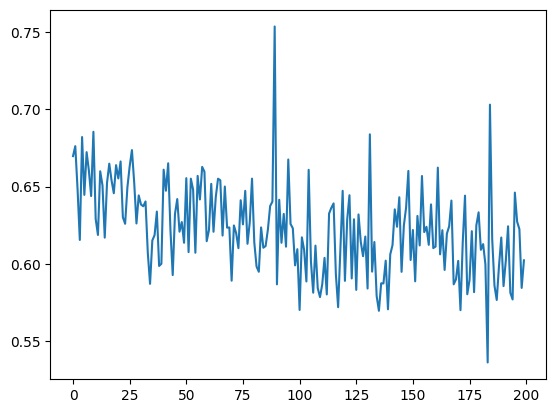

Train Accuracies


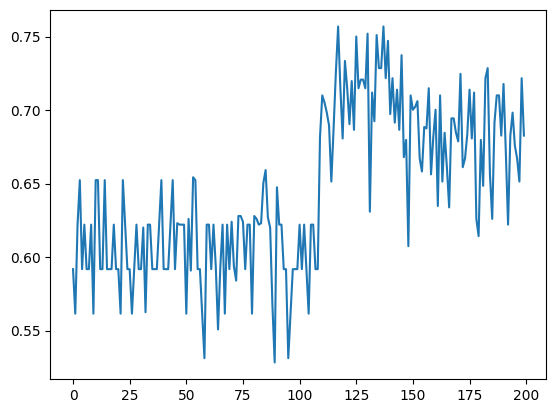

Validation Losses


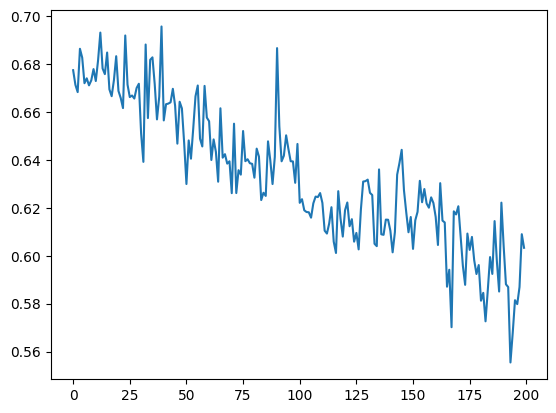

Validation Accuracies


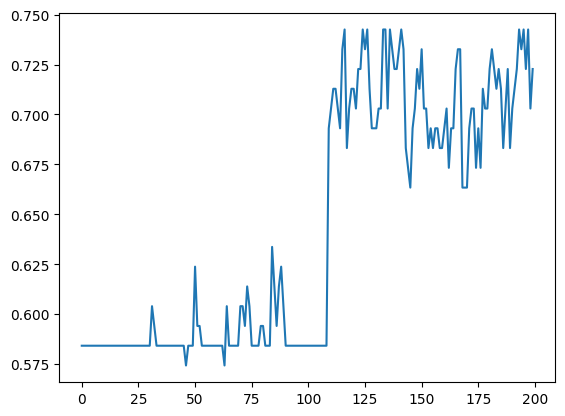

In [14]:
print("Train Losses")
plt.plot(train_losses)
plt.show()
print("Train Accuracies")
plt.plot(train_accuracies)
plt.show()
print("Validation Losses")
plt.plot(val_losses)
plt.show()
print("Validation Accuracies")
plt.plot(val_accuracies)
plt.show()

## Performance on the test set

In [15]:
seed_everything(77)
model.eval()
test_loss = 0.0
test_acc=0.0
for i, data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        test_acc+=acc
        test_loss += loss.item()

epoch_test_loss=test_loss/len(test_loader) # Average test loss
epoch_test_accuracy=test_acc/len(test_loader) #Average test accuracy
print(f"Test loss epoch {epoch}: ", epoch_test_loss)
print(f"Test accuracy epoch {epoch}: ", epoch_test_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]

Test loss epoch 199:  0.597978949546814
Test accuracy epoch 199:  0.7410714285714286


## Further Results

Inserting residual connections apparently boosts performances.
We remind that to have a complete map of our tests, please look at _experiments.pdf_ in this repository.